# Download several PPI resources and combine them into a single tsv

In [1]:
import zipfile
import io
import itertools

import pandas
import numpy
import seaborn

%matplotlib inline

/home/dhimmels/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
def order_genes_in_df(df):
    """Ensure that gene_0 is less than gene_1 and drop duplicates."""
    gene_0 = numpy.minimum(df.gene_0, df.gene_1)
    gene_1 = numpy.maximum(df.gene_0, df.gene_1)
    df.gene_0, df.gene_1 = gene_0, gene_1
    df = df.drop_duplicates()
    return df

In [3]:
# Download sources
# ! wget --timestamping --directory-prefix download/hid/ http://interactome.dfci.harvard.edu/H_sapiens/download/HI-II-14.tsv
# ! wget --timestamping --directory-prefix download/hid/ http://interactome.dfci.harvard.edu/H_sapiens/download/HI-I-05.tsv
# ! wget --timestamping --directory-prefix download/hid/ http://interactome.dfci.harvard.edu/H_sapiens/download/Lit-BM-13.tsv
# ! wget --timestamping --directory-prefix download/hid/ http://interactome.dfci.harvard.edu/H_sapiens/download/Venkatesan-09.tsv
# ! wget --timestamping --directory-prefix download/hid/ http://interactome.dfci.harvard.edu/H_sapiens/download/Yu-11.tsv
# ! wget --timestamping --directory-prefix download/ii/ http://www.sciencemag.org/content/suppl/2015/02/18/347.6224.1257601.DC1/Datasets_S1-S4.zip
# ! wget --timestamping --directory-prefix download/hetio/ http://het.io/disease-genes/downloads/files/protein-interactions.txt.gz

In [4]:
columns = ['gene_0', 'gene_1', 'source']

## Incomplete Interactome

https://dx.doi.org/10.1126/science.1257601

In [5]:
# read dataset inside of zipfile
with zipfile.ZipFile('download/ii/Datasets_S1-S4.zip') as zip_file:
    with zip_file.open('data/DataS1_interactome.tsv', 'r') as read_file:
        ii_df = pandas.read_table(read_file, comment='#', names=['gene_0', 'gene_1', 'sources'])

ii_df.tail(2)

,gene_0,gene_1,sources
141294,204851,2275,binary
141295,116173,8803,binary


In [6]:
# process so one PPI report per row
rows = list()

for i, (gene_0, gene_1, sources) in ii_df.iterrows():
    sources = sources.split(';')
    for source in sources:
        row = gene_0, gene_1, 'II_{}'.format(source)
        rows.append(row)

ii_df = pandas.DataFrame(rows, columns=columns)
ii_df = order_genes_in_df(ii_df)
ii_df.tail(2)

,gene_0,gene_1,source
193708,2275,204851,II_binary
193709,8803,116173,II_binary


## Human Interactome Database

[Documentation](http://interactome.dfci.harvard.edu/H_sapiens/index.php?page=home) and [downloads](http://interactome.dfci.harvard.edu/H_sapiens/index.php?page=download)

In [7]:
# HI-I-05
raul_df = pandas.read_table('download/hid/HI-I-05.tsv')
raul_df = raul_df[['Entrez Gene IDA', 'Entrez Gene IDB']]
raul_df['source'] = 'HI-I-05'
raul_df.columns = columns
raul_df = order_genes_in_df(raul_df)
len(raul_df)

2754

In [8]:
# Venkatesan-09
venk_df = pandas.read_table('download/hid/Venkatesan-09.tsv')
venk_df = venk_df[['DB Entrez Gene IDA', 'AD Entrez Gene ID']]
venk_df['source'] = 'Venkatesan-09'
venk_df.columns = columns
venk_df = order_genes_in_df(venk_df)
len(venk_df)

239

In [9]:
# Yu-11
yu_df = pandas.read_table('download/hid/Yu-11.tsv')
yu_df = yu_df[['Entrez Gene IDA', 'Entrez Gene IDB']]
yu_df['source'] = 'Yu-11'
yu_df.columns = columns
yu_df = order_genes_in_df(yu_df)
len(yu_df)

1167

In [10]:
# HI-II-14
rolland_df = pandas.read_table('download/hid/HI-II-14.tsv')
rolland_df = rolland_df[['Entrez Gene IDA', 'Entrez Gene IDB']]
rolland_df['source'] = 'HI-II-14'
rolland_df.columns = columns
rolland_df = order_genes_in_df(rolland_df)
len(rolland_df)

13944

In [11]:
# Lit-BM-13
rolland_lit_df = pandas.read_table('download/hid/Lit-BM-13.tsv')
rolland_lit_df = rolland_lit_df[['entrez_gene_ida', 'entrez_gene_idb']]
rolland_lit_df['source'] = 'Lit-BM-13'
rolland_lit_df.columns = columns
rolland_lit_df = order_genes_in_df(rolland_lit_df)
len(rolland_lit_df)

11045

## Hetio-dag

http://het.io/disease-genes/downloads/

In [12]:
# Entrez Gene mapping
url = 'https://raw.githubusercontent.com/dhimmel/entrez-gene/6e133f9ef8ce51a4c5387e58a6cc97564a66cec8/data/xrefs-human.tsv'
entrez_df = pandas.read_table(url)
entrez_df = entrez_df[entrez_df.resource == 'HGNC'].rename(columns={'identifier': 'hgnc_id'})[['GeneID', 'hgnc_id']]

In [13]:
discard = {
    'MI:0190(interaction type)',
    'MI:0208(genetic interaction)',
    'MI:0403(colocalization)',
    'MI:0914(association)',
    'MI:1110(predicted interaction)',
}

In [14]:
hetio_df = pandas.read_table('download/hetio/protein-interactions.txt.gz', compression='gzip')
len(hetio_df)

98187

In [15]:
hetio_df = hetio_df[hetio_df.interaction_type.map(lambda x: bool(set(x.split('|')) - discard))]
len(hetio_df)

96366

In [16]:
hetio_df = hetio_df.merge(
    entrez_df.rename(columns={'GeneID': 'gene_0', 'hgnc_id': 'source_code'})).merge(
    entrez_df.rename(columns={'GeneID': 'gene_1', 'hgnc_id': 'target_code'}))
hetio_df = hetio_df[['gene_0', 'gene_1']]
hetio_df['source'] = 'hetio-dag'
hetio_df = order_genes_in_df(hetio_df)
hetio_df.head(2)

,gene_0,gene_1,source
0,1,310,hetio-dag
1,2,310,hetio-dag


## Combine

In [17]:
combined_df = pandas.concat([raul_df, venk_df, yu_df, rolland_df, rolland_lit_df, ii_df, hetio_df])
combined_df = combined_df.sort_values(list(combined_df.columns))
len(combined_df)

319158

In [18]:
source_to_interactions = dict()
for i, (gene_0, gene_1, source) in combined_df.iterrows():
    interactions = source_to_interactions.setdefault(source, set())
    interactions.add(frozenset((gene_0, gene_1)))

In [19]:
# Interactions per resource
{k: len(v) for k, v in source_to_interactions.items()}

{'HI-I-05': 2754,
 'HI-II-14': 13944,
 'II_binary': 28653,
 'II_complexes': 31276,
 'II_kinase': 6066,
 'II_literature': 88349,
 'II_metabolic': 5325,
 'II_regulatory': 1335,
 'II_signaling': 32706,
 'Lit-BM-13': 11045,
 'Venkatesan-09': 239,
 'Yu-11': 1167,
 'hetio-dag': 96299}

In [20]:
# What percent of the interactions from the row source are in the interactions from the column source
rows = []
for source_0, source_1 in itertools.product(source_to_interactions, repeat=2):
    source_0_genes = source_to_interactions[source_0]
    intersect = source_0_genes & source_to_interactions[source_1]
    rows.append((source_0, source_1, len(intersect) / len(source_0_genes)))

overlap_df = pandas.DataFrame(rows, columns=['source_0', 'source_1', 'coverage'])
overlap_df = overlap_df.pivot('source_0', 'source_1', 'coverage')
numpy.round(overlap_df * 100, 2)

,HI-I-05,HI-II-14,II_binary,II_complexes,II_kinase,II_literature,II_metabolic,II_regulatory,II_signaling,Lit-BM-13,Venkatesan-09,Yu-11,hetio-dag
source_0,,,,,,,,,,,,,
HI-I-05,100.00,26.87,98.22,1.74,0.15,98.15,0.00,0.04,75.67,5.81,4.94,4.54,92.16
HI-II-14,5.31,100.00,100.00,0.85,0.09,9.19,0.01,0.00,4.79,2.94,0.47,4.77,9.41
II_binary,9.44,48.67,100.00,1.70,0.69,49.01,0.01,0.04,27.42,9.96,0.83,4.07,47.21
II_complexes,0.15,0.38,1.56,100.00,0.24,23.52,0.05,0.01,4.68,2.90,0.01,0.07,9.13
II_kinase,0.07,0.20,3.25,1.24,100.00,32.00,0.00,0.03,24.81,4.39,0.00,0.02,31.09
II_literature,3.06,1.45,15.89,8.32,2.20,100.00,0.04,0.07,32.55,9.78,0.26,0.22,53.77
II_metabolic,0.00,0.04,0.08,0.32,0.00,0.66,100.00,0.00,0.24,0.08,0.00,0.00,0.68
II_regulatory,0.07,0.00,0.82,0.15,0.15,4.79,0.00,100.00,3.37,1.20,0.00,0.00,9.89
II_signaling,6.37,2.04,24.02,4.48,4.60,87.94,0.04,0.14,100.00,15.51,0.31,0.31,88.74


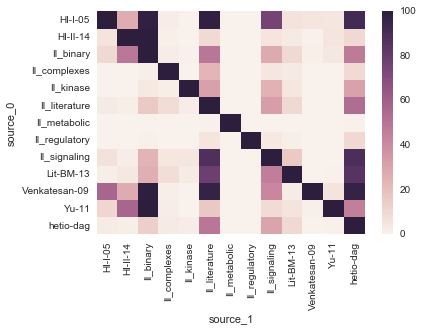

In [21]:
ax = seaborn.heatmap(overlap_df * 100)

In [22]:
combined_df.to_csv('data/ppi-sources.tsv', index=False, sep='\t')

## `hetio-ind` subset of interactions

http://dx.doi.org/10.15363/thinklab.d85

In [23]:
# Sources to include PPIs from
sources = {'HI-I-05', 'Venkatesan-09', 'Yu-11', 'HI-II-14', 'Lit-BM-13', 'II_binary', 'II_literature', 'hetio-dag'}
# Sources that qualify a PPI as unbiased
unbiased = {'HI-I-05', 'Venkatesan-09', 'Yu-11', 'HI-II-14'}

In [24]:
# Condense to gene pairs
hetio_ind_df = combined_df[combined_df.source.isin(sources)]
hetio_ind_df = hetio_ind_df.groupby(['gene_0', 'gene_1']).apply(
    lambda df: pandas.Series({
            'sources': '|'.join(sorted(set(df.source))),
            'unbiased': int(bool(set(df.source) & unbiased))
        })).reset_index()
hetio_ind_df.head(2)

,gene_0,gene_1,sources,unbiased
0,1,310,hetio-dag,0
1,1,1026,hetio-dag,0


In [25]:
len(hetio_ind_df)

151729

In [26]:
hetio_ind_df.unbiased.value_counts()

0    135203
1     16526
Name: unbiased, dtype: int64

In [27]:
hetio_ind_df.to_csv('data/ppi-hetio-ind.tsv', index=False, sep='\t')